In [9]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, t, ttest_ind
import matplotlib.pyplot as plt

### Population Distribution

In [10]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

In [11]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

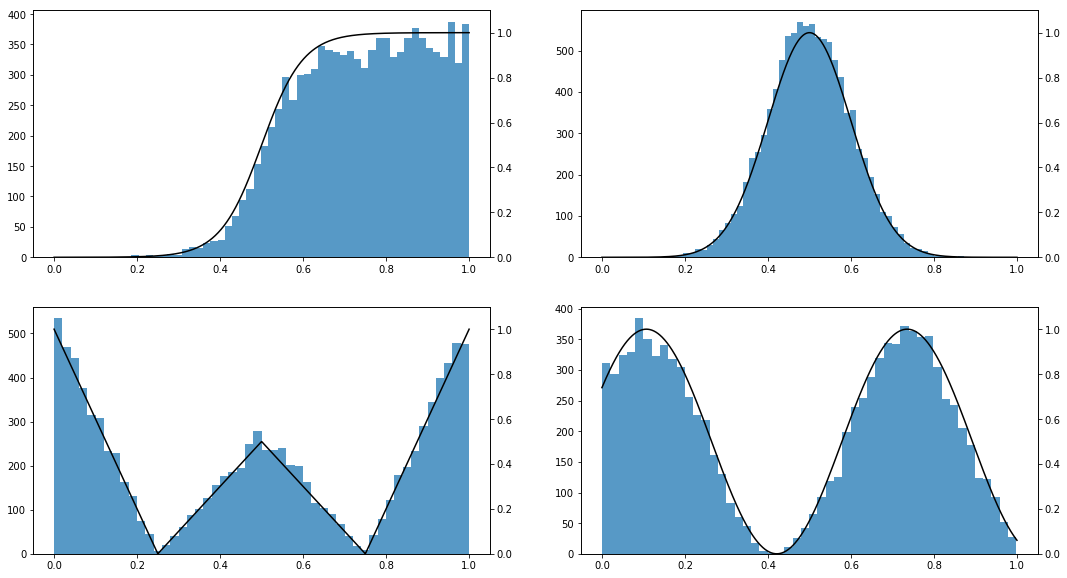

In [12]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
plt.show()

### Sampling Distribution

In [13]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

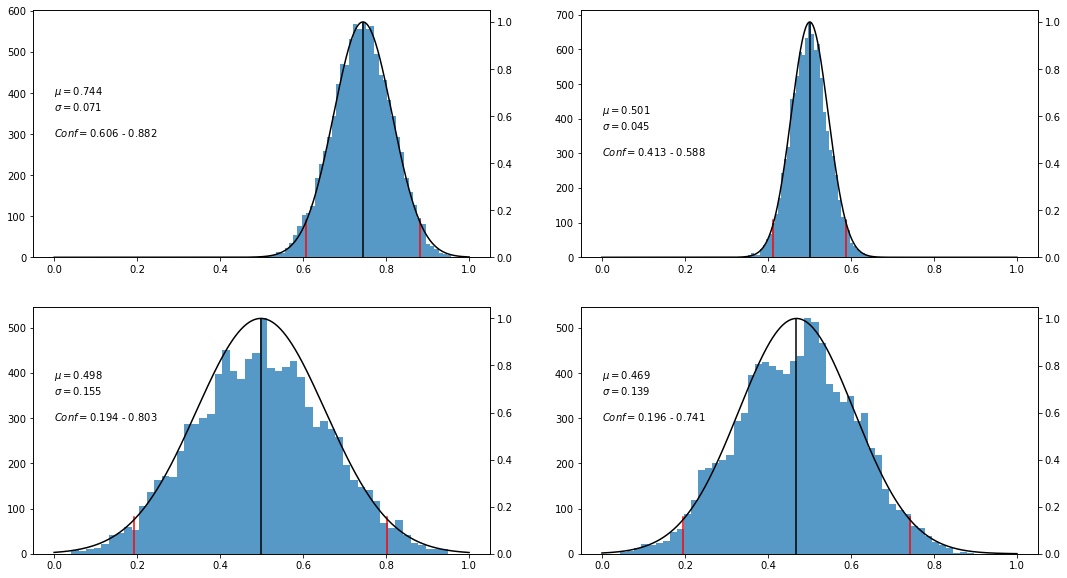

In [14]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

### Z & T scores

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [15]:
ZSCORE = 1.96
print 'Get Z-score from p-statistic: ', norm.ppf(.975)
print 'Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE)
print 
print 'Get CI from p-statistic: ', norm.interval(0.95)

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [16]:
TSCORE = 1.65
DF = 999
print 'Get T-score from p-statistic: ', t.ppf(.95, DF)
print 'Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF)
print
print 'Get CI/critical values from p-statistic: ', t.interval(0.95, DF)

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


### T-test

\begin{align} 
\overline{X}_D &= \sum^n_{i=1}{\left(X_{1,i} - X_{2,i}\right)} / n\\
S &= \sqrt{  \sum^n_{i=1}{\left(X_i - \overline{X}\right)^2  }/ (n-1)} \\
t &= \cfrac{\overline{X}_D} {\sqrt{  \frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}
\end{align}

### Independent t-test
Is there a significant difference between two same-sized but independent samples.

\begin{align} 
\overline{X}_D &= \overline{X}_1 - \overline{X}_2\\
S_D &= \sqrt{S_1^2 + S_2^2} \\
t &= \frac{\overline{X}_D} {S_D/\sqrt{n}}
\end{align}

In [17]:
# Given
mu1, mu2 = 12, 9
sd1, sd2 = 1.2, 2.7
n = 10

In [18]:
# Calculations
mean = mu1 - mu2
sd = np.sqrt(np.power(sd1, 2) + np.power(sd2, 2))
tscore = mean / (sd / np.sqrt(n))
tcrit = t.ppf(.95, n-1)

In [19]:
# H0 rejected?
print tscore, tcrit, tscore > tcrit

3.21080649534 1.83311293265 True


In [20]:
sample1 = norm.rvs(loc=mu1, scale=sd1, size=n)
sample2 = norm.rvs(loc=mu2, scale=sd2, size=n)
ttest_ind(sample1, sample2)

Ttest_indResult(statistic=3.0554019558038745, pvalue=0.0068116974539810552)

### Independent t-test
Is there a significant difference between two different-sized but independent samples.

\begin{align} 
\overline{X}_D &= \overline{X}_1 - \overline{X}_2\\
S_D &= \sqrt{\frac{(n_1-1)S_1^2 + (n_2-1)S_2^2}{n_1 + n_2 - 2} * \left(\frac{1}{n_1}+\frac{1}{n_2}\right)} \\
t &= \frac{\overline{X}_D} {S_D}
\end{align}

In [21]:
# Given
mu1, mu2 = 12, 9
sd1, sd2 = 1.2, 2.7
n1, n2 = 10, 15

In [22]:
# Calculations
mean = mu1 - mu2
sd = np.sqrt(((n1 - 1) * np.power(sd1, 2) + (n2 - 1) * np.power(sd2, 2)) / (n1 + n2 - 2) * (1/float(n1) + 1/float(n2)))
tscore = mean / sd
tcrit = t.ppf(.95, n-1)

In [23]:
# H0 rejected?
tscore, tcrit, tscore > tcrit

(3.2860496140088475, 1.8331129326536335, True)

In [24]:
sample1 = norm.rvs(loc=mu1, scale=sd1, size=n1)
sample2 = norm.rvs(loc=mu2, scale=sd2, size=n2)
ttest_ind(sample1, sample2)

Ttest_indResult(statistic=2.6727739830248769, pvalue=0.013591852681669242)